In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname='/nfs/users/nfs_e/er10/fonts/arial.ttf',
    name='my_arial')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['axes.labelcolor'] = 'k'
mpl.rcParams['xtick.color'] = 'k'
mpl.rcParams['ytick.color'] = 'k'

import seaborn as sns
import pandas as pd
import pysam
from liftover import get_lifter
import tabix
from scipy import stats
from scipy.stats import chisquare
import scikit_posthocs as sp
%matplotlib inline

In [23]:
data_root='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Revised/'
out_files='/nfs/users/nfs_e/er10/SGE/DDX3X_paper/Figure_plots/'

df=pd.read_csv(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation2.txt', header=0, sep='\t',index_col=False)
not_snvre=df.query('Variant_design_type!="snvre"')
snv=df.query('Variant_design_type!="snv"')

In [4]:
all_missense = not_snvre.query('Primary_consequence == "missense_variant"')
not_missense = not_snvre.query('Primary_consequence != "missense_variant"')
unchanged = not_snvre.query('SGE_functional_classification=="unchanged"')
fast_depleting = not_snvre.query('SGE_functional_classification=="fast depleting"')
slow_depleting = not_snvre.query('SGE_functional_classification=="slow depleting"')
enriched = not_snvre.query('SGE_functional_classification=="enriched"')

unchanged_miss = unchanged.query('Primary_consequence == "missense_variant"')
FD_miss = fast_depleting.query('Primary_consequence == "missense_variant"')
SD_miss = slow_depleting.query('Primary_consequence == "missense_variant"')
E_miss = enriched.query('Primary_consequence == "missense_variant"')

unchanged_not_miss = unchanged.query('Primary_consequence != "missense_variant"')
FD_not_miss = fast_depleting.query('Primary_consequence != "missense_variant"')
SD_not_miss = slow_depleting.query('Primary_consequence != "missense_variant"')
E_not_miss = enriched.query('Primary_consequence != "missense_variant"')

# expected number of missense = relative proportion of each SGE functional class * total no of missense

obs_missense=[len(unchanged_miss), len(E_miss), len(FD_miss), len(SD_miss)]
obs_not_missense=[len(unchanged_not_miss), len(E_not_miss), len(FD_not_miss), len(SD_not_miss)]
missense_not_missense = np.array([obs_missense, obs_not_missense])

exp_missense=[len(all_missense)*(len(unchanged)/len(not_snvre)),len(all_missense)*(len(enriched)/len(not_snvre)),len(all_missense)*(len(fast_depleting)/len(not_snvre)), len(all_missense)*(len(slow_depleting)/len(not_snvre))]
exp_not_missense=[len(not_missense)*(len(unchanged)/len(not_snvre)),len(not_missense)*(len(enriched)/len(not_snvre)),len(not_missense)*(len(fast_depleting)/len(not_snvre)), len(not_missense)*(len(slow_depleting)/len(not_snvre))]
exp = np.array([exp_missense, exp_not_missense])

print('enrichment: E', obs_missense[1]/exp_missense[1], 'FD',obs_missense[2]/exp_missense[2], 'SD', obs_missense[3]/exp_missense[3] )

# chi squared statistics:
chisquare(missense_not_missense, f_exp = exp)

enrichment: E 1.469582406721028 FD 0.717057761732852 SD 1.2323071830519694


Power_divergenceResult(statistic=array([  3.06559094, 157.94591252,  89.48736861,  28.85543028]), pvalue=array([7.99660823e-02, 3.18023581e-36, 3.08602550e-21, 7.79869475e-08]))

In [5]:
mutn_rates= pd.read_csv(data_root+'Supp_Table7_DDX3X_all_snvs_mutation_probs.txt', header=0, sep='\t',index_col=False)

mutn_probs={}
def collate_mutn_probs(row):
    var=(row['DNA_pos'], row['ref_base'],row['alt_base'])
    mutn_probs[var] = row['probability']

mutn_rates.apply(collate_mutn_probs, axis=1)   

0        None
1        None
2        None
3        None
4        None
         ... 
55147    None
55148    None
55149    None
55150    None
55151    None
Length: 55152, dtype: object

In [6]:
# Figure 3A

total_prob = 0
Grp1_probs=0
Grp2_probs=0
Grp3_probs=0
Grp4_probs=0
Grp5_probs=0
Grp6_probs=0
Grp7_probs=0

Grp1_protein_cons = []
Grp2_protein_cons = []
Grp3_protein_cons = []
Grp4_protein_cons = []
Grp5_protein_cons = []
Grp6_protein_cons = []
Grp7_protein_cons = []

Grp1_cadd=[]
Grp2_cadd=[]
Grp3_cadd=[]
Grp4_cadd=[]
Grp5_cadd=[]
Grp6_cadd=[]
Grp7_cadd=[]

pop_dB_vars=0
Grp1_pop_vars=0
Grp2_pop_vars=0
Grp3_pop_vars=0
Grp4_pop_vars=0
Grp5_pop_vars=0
Grp6_pop_vars=0
Grp7_pop_vars=0

# hg38 coordinates
DDX3X_start=41333284
DDX3X_end=41351668
#sequence includes 5'UTRs and introns, i.e. is gDNA sequence of the above coordinates.
DDX3X_seq='CCCGCTGCCTAGGCAACCGCGCAGGAAGGTGTCCGGCCACCTGCGCGCGCCGCCGGCTCCCCTCCATTTCCCCCCGACTCCCGCCCCGGTCACCATCCTACCCTCCTCCCTCCTCCTTTCCCCTTACTCCGCTCCCCTCTTTTCCCTCCCTCTCCTCCCCTTCCCTCTGTTCTCTCCTCCTCTTCCCCTCCCCTCCCCCGTCCGGAGCACTCTATATTCAAGCCACCGTTTCCTGCTTCACAAAATGGCCACCGCACGCGACACCTACGGTCACGTGGCCTGCCGCCCTCTCAGTTTCGGGAATCTGCCTAGCTCCCACTAAGGGGAGGCTACCCGCGGAAGAGCGAGGGCAGATTAGACCGGAGAAATCCCACCACATCTCCAAGCCCGGGAACTGAGAGAGGAAGAAGAGTGAAGGCCAGTGTTAGGAAAAAAAAAACAAAAACAAAAAAAACGAAAAACGAAAGCTGAGTGCATAGAGTTGGAAAGGGGAGCGAATGCGTAAGGTTGGAAAGGGGGGCGAAGAGGCCTAGGTTAACATTTTCAGGCGTCTTAGCCGGTGGAAAGCGGGAGACGCAAGTTCTCGCGAGATCTCGAGAACTCCGAGGCTGAGACTAGGGTTTTAGCGGAGAGCACGGGAAGTGTAGCTCGAGAGAACTGGGACAGCATTTCGCACCCTAAGCTCCAAGGCAGGACTGCTAGGGGCGACAGGACTAAGTAGGAAATCCCTTGAGCTTAGACCTGAGGGAGCGCGCAGTAGCCGGGCAGAAGTCGCCGCGACAGGGAATTGCGGTGTGAGAGGGAGGGCACACGTTGTACGTGCTGACGTAGCCGGCTTTCCAGCGGGTATATTAGATCCGTGGCCGCGCGGTGCGCTCCAGAGCCGCAGTTCTCCCGTGAGAGGGCCTTCGCGGTGGAACAAACACTCGCTTAGCAGCGGAAGACTCCGAGTTCTCGGTACTCTTCAGGGATGAGTCATGTGGCAGTGGAAAATGCGCTCGGGCTGGACCAGCAGGTGAGCCGCAAGAACCCCACCGGGCTGGCTGCTGCGTGAATTCCTCCCCTGACCTAACCTGGCTAATGGCGCAGCGCTAACCGGCACCCTTACTTTTCATTTTCTGGGTGCCCCGGGCTGGCGGGTGTGAGTGCCCCGGGGCTATAGAGGGATAGGAATGTTGGTTGGGGCTGTCGCCCGGGCCCGGTCTCGGCCCGCTGTATTGTCCCCGGGACGAGCACAATGGCGGCTTTTGTGTGTGCGTGCGCAGGCGGGCGGAGGGGGAGGAAGTGCGCGCGCTCTCGCGGGGACGCGCATGCGCGAATCCCGACTGATTAGTGACCTGGGGGGGTTTGCGGGAGTGCGCAGCGCGGCGGGACGCGACTGGAGGCCCTTTTGGCTTGGAGGGCTTCGGCCTTCACGGCTGGCGCAGCCTGGATTCCCGTCCGGAGGACCTGGCGGCACCCGGTGTTTGCGTGCCTGCGAGCAAGGGGTAGAACGCGGCCCAGGAATGTGGGAGGGGGCGGCCTTCGCTCGGGGTAATGGCGGCGGCCTCTTTTGTGTGGTGCTGGGCGGCGCTGTGGCTCACCTCCGGGAGACGGCGGGTCTCGGGCGGGCGAAGGCCTGGAAAGGAGGATGGAATGGGTTTCTTGTTTTTTCCCGGGTTCCTTCCGCTGGCTTTTTCGCTTCAGCCCAGGTTCCGCAGGGTCCGGGGGCCCTGCGCCGCAGCCGGGGAGGCTGCGTTTCCGGAGTGGAAAGTTTTGTGACGCAGAAGATTGGGGAGGAGTGGGGGAGGGGTGGGGGCGGGGAGGGGAGGCAGGAATTGGCCGCTGCGCGCTGGGCCCTGGAGATAGAGGTTGGACGTGGCGGGGAGGTTAGGGAGCCAGCGAGGCCCTTTCTCCTCCTTGCTTGCCCCAGATTGTCCCTGTGTGGTATGTTAGCCGGGAGTCCCGCGTTGTTTTTCTGGGGTGGAGGGGTCATCGCGGGTTGTGGTAGTGTCTTCGTGTTAGTGACTGTGATCCAGGAATCCGCCATTGGAAAAACACCCGGCTTAGGGGGGAAGTAAACAGTTTTGTTGTTGACTTGTTGCTATCTGTGGAGTAGAATCTTGCAATGGGTCCCAGGCCCCCGGGTTTTTTCTCTTAGCCAGAATCCCCTCTTCTAAGGGTTTAGGGGCAGAGGAGAGAAAGATGTGTGATTTGAGAGGAGAAGGTTATGGACTTTGGTGGCAGGAAGTCTGCATCCCACCGCAACAGTGGCACCAGGCTTCAGATAAGCTCTTGTGTGGGTTATGCGGAGCTTTTAAATAAACTACTGTCTACTGTGATTAGGGGAGCGTTGATTTCACAAACTCCGGAATAATCCTGAGACGAAGTTTAGTGGCACAAATTAATTGAATACATAGTTTAATGTAGTCATATGTAATATTTTTTAGGAATTGATCTGTTCCTTTGGAAGCATTTTCTACCCGTTAATGAACCAATTATATTAAATCCTCTAATTGCTGACACATGTTGAATTGAACAGACACTTTAACAACCTACCAGCAGCACAGAGTATTCCCAGTTTTACCATTTTCCATTTAGCTATAGTGTCCTTTTAAGGATTCTAGGCAACAGTGAACCTTATTTAAAAAGCAAAATTGTGCTATAACAAGTGCAAAAGGAAAGTTTGTGTTCCTACCGTGCTTTAAAGTATTGATGGTAGCAAGAGAAAGCGCAGTGGTGTTTTTGCTCATAGAAATTCTGGAAATTAGGTGCCTGAAGTCTTACACTCATTTTTTAAAAGTATAGCATCTGCTTCCAGTTTTCAGTGACTCCATTGATGATGCATGCGGTTTGGCCGTATCATACTGAGCTTTAAACACAAGATTTATAAACATGGTATGTAGTGCATCTTTTGCAAACAGGTTGGCAGCGGTACTGTGTGACTTGGTCTTTTGTGGCTTTTTTGAGAAAAATGAAACACTTTGCATGTATAGTTTTTTCTCCCAACTACTTGTGAGTAGTTCCTGGTTATAAAACGTTATGAAGGTAGCACATAACCCTTTTCTAGAATGAAGAGGCTTTTGAGCTACCAGTGTAAGGGGATAGGTAGAAATAGAGATGAAAGGCACTAAGATGTCCTACTCTTTAAGAGCATTGAACGCCAGTTGTGCCATTTATTCAAAGTCATCTTTGAACTTATGTTAAAATGGGGTAAAAACAGGTAACTACTTCAGGCCGGGCTCATGCTTGTAATCCCAGTGCTTTGGGAGGCCAAGGCAGGTGGTTCACCTGACCTGAGGTCAGGAGACCAGCCTGGGCAACATGGCGAAACCCCATCTCTACTAAAAGTACAAAAAGTAGCCTAGCGTGGTGGCGCACCCCTGTAATCCCAGCTACTCGGGGAGGTGGAGGTTGCAGTGAGCCGAGATCACATGACTGAATTCCAGCCTGGATGACAGAGGGAGACTCTGTCTCAAAAAAAATAAAAATAAAAACAAACGAAACAGTCAAACTACTTAAGAGTTGTGCTTAACATAGTGTTCTGTAAGTGGTAGGTATATTGCTATTTTTTTGTTGTTCTTAAGAGTACTACCCGACTAAAAATACTTGGGCAATATTTAGGGATGAAGTATCTAACTAAAAGAACGGCCACTTCGAAATTTGTCCTGACATTTTTCAGGTGTGCATTTTAGGTTTAAAATATCAAGTATTACGGAAAGTTGGCATTGGAAACTTTCATAACCGGCACTAAAACGAATCCTTTATCTATTTGACATTGAGGAATAATTTTGAGATTCAGTGTAAGCTTTAGTTTGGTGATTAGGGAGCCTGTGCTATGGAACATGTTAGTGAAAATTTATTTTGAATGCATGAATTAAATTTGGACAGTTTCTACTGAACAGCACAAGCATCTTGGTGTGCCGCCTTCTGTAGTATATACAATAGTAATATTGCATTTGCTTAGAGCATTGCAGACTTGAAAACATTCTTAGTCACATTCTCATTAAGGGTTGGTATTAGCCCTGTGAGGTGGACTGGGCAACTACTTGAATGCAGTACTAGCAAATGCTAGAGGGCAGGACTAGTTTTCTCTTAATGTAGTATTTGAGCACATGGGGTGCTAACCATCTCACTCTCTTCTAGTTTGCTGGCCTAGACCTGAACTCTTCAGATAATCAGAGTGGAGGAAGTACAGCCAGCAGTAAGTACAACATCTTGTGGGTTTATTGAATATTAGAGCTTAACATCTTAAGATTTCATTGGGCTTATGTAAAATTTAAGAAATTTGCCTTTCAATTTTTTACTGCTTAAAGAATTATGTAGTCTTTGTGTTATAGAATTATGTAGTACTTAGTGATCAATCTAAAGCATCGTTGCCTTTTTTTTTTTTTTTTGGTTGAGATGGAGCTTTGCTCTTGTTGCCCAGGTTGGAGTGCAATGGTGTGATCTCGGCTCACCGCAGTCTCTGCCTCCGGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCGAATAGCTGTGCCTTTCTGATAATAAAACATCAATGACTAGCTGGCTCTCTTGAGTAAAAGCAGCTAATCATTGGAAAGAACCTTATTATATCAAATTATCTCTAGAAGAGTTTTTGTCCATTATAAATCCTGAGCCCAGTTTAGAGGTGATGGGAATGTGTCCCTGTTAACTGACTATATTTATTAAATTGAATTAAGGGAATATGCATTTCATTGGTTATAGCTACTCCTTTCTCCTGAAGAACAGAAGACTATACTGAATTTTGGATTGGTGGTTAGGTTAGGTTTTCAAATGTGTCATTTCTTTTAAAAAGGCATTAGAAAAGTTGCTTTTTTTCTTCTAAGGGGGGTTATTTAGAGACTTGTTAGAGGTTAGTGTTAAGATAGGGGATCTTGGTGGTTTATTATAAGGGCAATAGACCCTTATTTTTAGCTCAGATCTCTTCCTACTTATTAAAACAAAAGTGAGTATGGGCTATGATGTGTCCTCATTTTTAGGCAAGAACAGCTTCACTGGGAACAAAACTTGGTGTTTGCTTTAACTTTCACCTTATTTGTCATGCTAAGAATCTTTTAGGAACTGATTGTCCTAGTAGAGATTTTTAAAAATATTTAATTCAGTCTAGAAGTGAAAAAGAAAAATGACACGTTTACTAGTTATAAAGCAAATTTATTTGGCTTTATGTTGTTTTTTTTGCTTATCCATATTCTAGGCTGTACTCCTGCTCGCATACAGAGCAACTGTCAACTTTCCTTAAACTCAGCAAGCCCCAAATTAAAACCTGCAATTCCTTGAAATTAACTCCCCTTTGCAGCTTTTCCTTGTTTATTTATTGTATGTTTTGCAACTTACTGGCATAGAAACAAAAGATTGTGAGATATGTTACATGAGTAATCTTAAATTGTTACAGTAATACTTAATGCTTTTGTTGACAGTTTTGATGACAGTTCTCTTAAATCTAGCAGGCCTTTAAAAAAATCACATTAAATGACCACTGGTGGCTAAATGTGCTCAATTTGTGGATTTCAACTATTAGGTTCCAAATCAGCTTTTTTTTATCAAACTCCTTTCAGAGTTCTCCTTATGAAGCAGTAACCCATTTAAAATTAGATTCTTATTTTTCCCCCCTCTCAGTGTCCAGGTAAGTAATCAGATTGGAAGGCTGGAGATTTTAATTTCCCAGAACCATTTTTTAGTAACAGAAATTTAAATGGGAAGGTTTTTTGGCATTTAATTAATTTTATATATATATATATTTTTTTAGAAGGGCGCTATATTCCTCCTCATTTAAGGAACCGAGAAGCTACTAAAGGTAGGTCCTCACAAGTAACTTCGTAGGTCTATTTTTTGCCTCCTTTAGAAGTTAGTAAAGCCTAAGGAAAACCAGGCATTTGGGGGAGGTCTAAACATGGTGTTGTTTTTCTATGCTTCTGTCAGCCTTGGTTCAAATACTAGAGCTTAATAATTTTGGAAGAACTCATCTAATGTTACGCAGTGGGAAATTCGGCATTCCTATGTCAAACTGTTCTGACGCCAAGGGCATGGTTTTGTACAGTTTCACTAGTGTTGTGCTGAATCTGTTTGTAATCATTCACAGCATGGTTTTAGTTTGGAAGAGGTGGGTGCCCTACTGTGTAAACCAAGCTGTATAATGATAACAACCTGGTTATTTCTGTCTTGGCAAAGTTGCTAGAAATGAAGATGGGCTTATTGTAGAACAGTTAACAAGTTACAGCGTTGGAAGTGATTCTCTGGTTTCATCTCCTTGCCTTGCTGCTTTTGAAAGGTTTTGTCCAAAATGTATTACAATATCTGGTGTCTTTTCCCATTGTAATTGTAACGTAGTGATAGATGACAGCTAGTATATGTTTCATATTATGAGACAGCTGTTCGGGTGCTTTATATTCTGTAAAATAGACCATCCAAAATTTGGAGGAAAAGGGAAAGTCAGGAAAACCAAAGATTAGGAGGGAAGATACTGTATAAAGAAGGCAGATAGGAAGAGTGGAGAGTCCACAGGGGAGCACATGGTTTGCTGCTGTTCCTCCATCTCCATATGTAGTCTGTATTACCTTCACTGTCCTGGCAATGCATGGATATAAAATCTGTATTATTTCTACCAGAAGATCACTTTGGCTTTTTTTTTTTTTTTTTTTTTTTGAGACGGAGCCTTGCTCTGCTGCGGAGGCTGGAGTGCAGTAGCGCGGGCTCACTGCAACCTCCGCCTCCTGGGTTCAAGTGATTCTCCTGCCTCAGCCTCCCAAGTAGCTGGGATCACAGGCATGTGCCACCATGCCCGGCTAATTTTTGTATATTTAGTAGAGACGGGGTTTTGCCTTGTTGCCTAGGCTGGTCTCGAACTCCTGACCTCAAGTGATCCACCCGCCTCAGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCATGCCTGGCTGGCATTATATTCTTTTTAGGGGAGGTTACTTTGGAATTTGTCTTTATCATCATGGATGTTCTCAATATTCCTAGTATACTAGCTAGAATTGACCCTCGTGTATATGGCAGTATCATAGAGGTTTTAGAGCTGGTAGAGATCTGGCAATCTAACTTAACTCTTTCTTGCTAGCAAAGGCTGTTGGTCACCTGACTGGCCTAACGGTAGGAGGTAGAAGGCAGAAGGAAAGTAACTGAATTGAGAAGCTGTTTCTGTTTAATAAGGTGTTGCTGAAGCTAGTTAAACCCTCTACCTGTCTTTAAACCCTCTACCTGTCTTTGGGTTAATTTACATGTTTGTCATCCCCTTACCTGGATATTTATAGCTGTACCCAGGAACCTTGTCTATACTGAGAATATATAGTGATGAGGGTTTTTCTTTTTCCCAGGTATTCCTGATTGTCATCAAGCTTATAGTAGATGAACCACTAAAATAATACTACAATTTGACATTAGTGTTCTTGTACTTTATACTATTGAAACTGAAAAATACTGTATTAAACCAAGTAATCTGACAGTCTATGAATGTTCTAAATGAATACCACCTCCAAGAAACATGGAAACAATGGTAACTGTTTTTCCTAGTAAACTCATTCACACCTATAAAATGAATGGAAATTAAATTGTTATGGTCACACAACGTCATAATGCGTTACAGGCAAAGCTGTTGACCACTTAGAGGTAGTATTCATTGAGAAACATTCTTAGACTGTCAGATTGCTTGATTTAGTGTAAAGTAATTTTTTTTTTTTTGAGACAAGGGTGTTTCACTCTTGTTTCCCGTGCTGGAGTGCAGTGGCGCAATCTTGGCTCACTGCAACCTCAGCCTCCCGGGTTCAAGTGATTCTCCTGCCTCAGCCTCCTGAGTAGCTGGGATTACAGACGTGGGCCACCACGCCTGGCTAATATTGTATATGTAGTAGAGACGGGGTTTCTCCATGTTGGTCAGGCTAGTCTCGAACTCCTGACCTCAGGTGACCTGCCCGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGCGTGAGCCACCATGCCTGGCCAGTGGACAGTATTTTCTAGTGGGGAGAATTAAAGAAAAACTTTGTCCGGGTGTAAACCAGCTTTAAATCTTGGTTCTCTTACAGTGCCATGGTAGGGATAGTCAGTGGAGGCTTTCAAATTCAGAAAGATTGATAATACCTTAACATGGTTCCTATTTCTAATTAATAATAAAATGTATTTGTGCTTTTTTAATCAAAGGTTTCTACGATAAAGACAGTTCAGGGTGGAGTTCTAGCAAAGATAAGGATGCGTATAGCAGTTTTGGATCTCGTAGTGATTCAAGAGGGAAGTCTAGCTTCTTCAGTGATCGTGGAAGTGGATCAAGGGGAAGGTAAGTGATTTCTTAATCACCTTACGTGTATGTATAATAACAGTTTAATAAGTCGTTATCCTGACCACCTGTTTGGATGTTAAGCATTATGTCTGTTTGGTCATTGTATTTTCTTAGCCGTAAGAGGCTTTTACTAAATTGAACCTGTTACTTAGAAATTAGATGAAAATAGGAATATGCTCATTGGCATAATGAAATGAGTTATTCTATTTCTCGAGTTTTATATGTTCTACTTAAAAGAGTAAGTTCATCTAGTGAATGGCCTAATTTGGTTGGGATTTTTGTGGACTCTATAACAATTTCTAAACACCTTGTATTTTTGATTACACAAGTGTGGTGAACTGACCCCACGTGCCTAATAGCTGTGGTTAGTCCTGTGTCCTGATTTTTCGCAAACAGGCCTAAAACTCTTAAAAACATCTTAGTTCAGGTAAGGATTATTTTCTACCTTTTATCCAAAGTCTGTCACACAGGTGAATTGTCCTTTAAGTGACATCCTAGTATAACTAGGACGATTGATATTTGGTGTGCTATTTTCTTGTTTTCCCTACCATTAAATATATTTGGATGAGCACTTTAAATGAAGGTTGTGAGCTGTGTGCCGATTTCAAATAAAATCCTTATTCTTAATTTTGGCATCTGTGAGGCCTTTTAGGCTATACAACTTTATAGAAATGTAAAGATTACTGATTTTAGAAAACGAGGTTATGTAAATGATGCTGGTTAGAGAGCCTTATTTGTCAAGTAACTCAGAATTGGATTGTTGACATCCTTATGGTTAGCCATAACTTAAGTCTCCAGATACAGTTCTAGAGTAGGGATAAGAATCTGATAATGGTTAAATGATATGATTCTGATTAATTGCTTGTGCTGTTCAGGTTTGATGATCGTGGACGGAGTGATTACGATGGCATTGGCAGCCGTGGTGACAGAAGTGGCTTTGGCAAATTTGAACGTGGTGGAAACAGTCGCTGGTGTGACAAATCAGATGAAGATGATTGGTCAAAACCACTCCCACCAAGTGAACGCTTGGAACAGTAAGTTTTTGAAGTGTATGTTACTTGTGATGAAGCCTTACTAGCTAGTATAACAAATGAACTTATCCATTTTTTGATTTGAGGGAACTCTTTTCTGGAGGCAACACTGGGATTAATTTTGAGAAATACGATGACATTCCAGTTGAGGCAACAGGCAACAACTGTCCTCCACATATTGAAAGTGTGAGTATTTTTGCTTGACTTTTTAAGACACAGAGAGGTTAAATGTTTTCATGTTACATTAGAATGTGAGATGGGCTTCATAAAGTCATGTAGACCAGAGGCTTCATAGATTTGTGGAAAAGGAGAAGTTGAGTTCAGTGTCACCATTATGAATAATTTATTACCTAAAATAGAAAATGGGTCAAACATAGGAACAACCCAAAGTCTTCTCCAATGTGCAGTAAGCCTGGGGGTTGGTTTTTCTCAAAGTATAATGTGATAATTTTACTTAAACTATAAACTGAGTTACCAATCAGCTGTTGGTTGGTTGTTTCCATTATTAGTATAAAACAGAAATAGCTCTAGATAGCATTCCTAACCCCATTGAATTTCTTAACAGTTCAGTGATGTTGAGATGGGAGAAATTATCATGGGAAACATTGAGCTTACTCGTTATACTCGCCCAACTCCAGTGCAAAAGCATGCTATTCCTATTATCAAAGAGAAAAGAGACTTGATGGCTTGTGCCCAAACAGGTAAGCTCAACTCATAAGAGTAAAACATCATATTTCTTCTGTAAAGGACTAGACAATAAAATATTTTATTTTTTATGGGTCATGCAGTTTTGCAGCTGCTCTGCGCTGCTATTGGACTGTGAAAGAAGCCATAGATGATACATAAATTATTGGTTACGGCTGTATTCCGTAAGAGCTTTATTTATAAAAATAACAGGCTTTATTTACAAAATAGTCTCAGTTTGCTGACTCCTCTTAGAGGTGGAGCAGAGAAGCCACTTTTTGGAAAACTTAAGCATAAACTAAAAGTACTAATTATTAGTAATAGGGTAGTTAAAAAACACTGTCATCTACCAATGTCTGTTTAAAAGTAATGAGCAGGATTTGTTTGTTTGTTTTTGAACAGGGTCTGGAAAAACTGCAGCATTTCTGTTGCCCATCTTGAGTCAGATTTATTCAGATGGTCCAGGCGAGGCTTTGAGGGCCATGAAGGTAGATGTTTCTTTATAAAATGGGAAATTGTAGAACTTTGTAGGTGGCCATTGAGAGGGCTTTCTAAATGATGCTAAGACTTAAGTAGAATGAAAACCAGTTTTCAAGTGTAATCTGTAATCTATAAATTACAAAAGGGAATTATGTTGTGATGAACTTTTCAAACAGGGTAGGTAGAGTTAACTTAAAAATTAACTTATTTCTTAGGAAAATGGAAGGTATGGGCGCCGCAAACAATACCCAATCTCCTTGGTATTAGCACCAACGAGAGAGTTGGCAGTACAGATCTACGAGGAAGCCAGAAAAGTAAGTATGAGTTCCAGTGATTATTAGCTTTTTCATTGATTCTAATTAAATGTTTTATGAACATGTAAAAATTTTGACCTTGAAGTTCATAACATTTTTTTTGCTTATAGTTTTCATACCGATCTAGAGTTCGTCCTTGCGTGGTTTATGGTGGTGCCGATATTGGTCAGCAGATTCGAGACTTGGAACGTGGATGCCATTTGTTAGTAGCCACTCCAGGACGTCTAGTGGATATGATGGAAAGAGGAAAGATTGGATTAGACTTTTGCAAGTATGTTTTATTTTGTTTTTGTTTTTTTGTTTTGTTTTGTTTTGTTCTTTTGTTTTTGGCAGAGTTGCGCTCTTGTTGCCCAGGCTGGAGTGCCATGGCGCGATCTCGGCTCACCACAACCTCTGCCTCCCGGGTTCAAGCGATTCTCCTGCCTCAGCCTCCCAGGTAGCTGGGATTACAGGCATGTGCCACCACGCTGGGCTAATTTTTGTATTTTTAGTAGAGGCGGGGTTTCTCCATGTTGGTCAGGCTGGTCTCGAACTCCTGACCTCAGGTGATCCGCCTGCCTTGGCCTCCCAAAGTGCTGGGATTACAGGTGTGAGCCATCGCACCCGGCCAAGTATGTTAATTTTTAAATGTATGGGATGCAGTATTAAAGTTACTGCCCATTAGTTTTGTGGTGATGTTAACATTGTCTAAATGTTAAGGCTGAGAAGTGATGTATTTCAGACATCTAACTTTCACAAAAAGCTTGTTCATGGTAATTTTAATGTTGAAAAATCAGTAACATCTTGGTTGAGACTTACAACAATGATCAGCTCGTGGGACAGTCAACTAGGATGGGCTAATTTGACTGTGTAATCTTGAATGACTTATGTAGTGGCAAGAATCCTGTGCTGTGTCTGTAAAATTATGCAGTGTGAGGCACCATCTTAATGAATATATAATTGTAATAACCTATACAATTGTATTTGTAATTATACTAACAGCCATACTAAAACCATGTTGATTTCTCCTCAAATTCTAAACTCAGGCTTGTTTTTTTTCATGACATGACAGATACTTGGTGTTAGATGAAGCTGATCGGATGTTGGATATGGGGTTTGAGCCTCAGATTCGTAGAATAGTCGAACAAGATACTATGCCTCCAAAGGGTGTCCGCCACACTATGATGTTTAGTGCTACTTTTCCTAAGGAAATACAGGTACTGTTTGATGTTGCAAATTTTATTTATTTAGAAATTTGTTTATCTCAGGTAATAATAAAAATTTTTTTTCTTTCAGATGCTGGCTCGTGATTTCTTAGATGAATATATCTTCTTGGCTGTAGGAAGAGTTGGCTCTACCTCTGAAAACATCACACAGAAAGTAGTTTGGGTGGAAGAATCAGACAAACGGTCATTTCTGCTTGACCTCCTAAATGCAACAGGTAACATTATGAATTTTTTATTTTATTAGACATGGGGGTTTCTCTTTGTTGCCCAGGCTGGAGTGCAGGGGTTATTCACAGGTGTGATCTCATTACTGATCAGCATGGGAGTATTTGACCTGCTCTGTTTCTGACCTGGGCCTGTTCACCCCTCCTTAGGCAACCTGGTGCTCCCTTGCTTCCGGGAGGTTACCATGTTGATGCCAAACTTAGTGTGGACACCTGATAGGCATAGTACACTACAGCCCAGAACTCCTAGACTTAGACAATCCTCCTGCCTCAGTCTCCAGAGTAGCTGGGACTACAGGCACTCACCACTGCACCCAGCTAAAATTATGAATAATTTAATTGCTCTGGTAATAACCCATTTGGGCTGGGTGCAGTGGTACAGTGCATGTAGTCCCAGCTACTTGGCAGGCTGAGGCTGTAGTATGCCATGATTGCACCTGCGAATGGCCAGTGCACTCTCAGCCTGGGCAATTTAGTGAGACCCCCATCTCTTAAATGTATTTGGATTACCTTTATTACTTTTCCTCCTCAATTCAAAACATGCTGTGTTGAAAGCCCGTTTTTAAGAAGATATATATGTATTTTAATTGACACATTAAAATTGTGCATACATAAGTGCAAAGAGAACTAAGCCATGTTAGTGACAAAAACCTATAATTTTTCAACGACAGGCAAGGATTCACTGACCTTAGTGTTTGTGGAGACCAAAAAGGGTGCAGATTCTCTGGAGGATTTCTTATACCATGAAGGATACGCATGTACCAGCATCCATGGAGACCGTTCTCAGAGGGATAGAGAAGAGGCCCTTCACCAGTTCCGCTCAGGAAAAAGCCCAATTTTAGTGGCTACAGCAGTATGTATAAACATCTTTCTTTTATTCAAATTGAGCATGTTCAAGTATTTGTTTTCTTTTAAGTGGGCCATATCTCATAAAAGTTATTTTCCAGGTAGCAGCAAGAGGACTGGACATTTCAAATGTGAAACATGTTATCAATTTTGACTTGCCAAGTGATATTGAAGAATATGTACATCGTATTGGTCGTACGGGACGTGTAGGAAACCTTGGTAAGTATTTGATTACTTGATGGTTTCATTGTTTTTTGCTGTGATGTGTGCAGGAAAGAACTTGCTAGGATCTAAAATACATTTTTAACAATGAAAGTGACAAAGATTTTGCTCAAAGCACTTGTTTAAATATTACGTGGTAATATTTTAAATATTTCTACGTAGGAAAGTAAGAATAGTAGCAAGTTACTTTATGGAAGACCTTTGTTTATATACTTTTTTGGGAACTCTTTTAGGCCTGGCAACCTCATTCTTTAACGAGAGGAACATAAATATTACTAAGGATTTGTTGGATCTTCTTGTTGAAGCTAAACAAGAAGTGCCGTCTTGGTTAGAAAACATGGCTTATGAACACCACTACAAGGGTAGCAGTCGTGGACGTTCTAAGAGGTGAGGTATAAATAGTATATAATGAGGGGAATGGGTGTTCACTTACAGTTCATAGTGTTTCCTCTGCATGCATAACGTCCAAGGTTAACTGTACAGTATTTAAAAAGCTTAATCATCTTAGGCTTCCTAGATTCTTTGGTAAGGGGTTGTATTAGAATGGGTGACACTCTGTTGGGGAAAATATGGCTGGATGGGGAATTGTTTGAATGGAAAAATTAGAAATTGGTCATTAGGAAAGAGTTAGGTTACTTTAGTGGAATTTCATCTTCATGTGAACCAACATAATTTTTTTCTTATAGTAGCAGATTTAGTGGAGGGTTTGGTGCCAGAGACTACCGACAAAGTAGCGGTGCCAGCAGTTCCAGCTTCAGCAGCAGCCGCGCAAGCAGCAGCCGCAGTGGCGGAGGTGGCCACGGTAGCAGCAGAGGATTTGGTGGAGGTAGTGTTAATCTGTAACTTCATAGCTTTGGGAAGGGTTTTTTTCCTTTTAGTCATCTTTTTCAAAGCCTAATTAAACAATTTAAGTTCAGCACTATAGAAACTTGATGGCAAATTACGTAAGGGAAGGATTGTATTTAATGATGGATAACTTCATTAATTTCTCTCTCTTTTTAAATCTCTCATTAGGTGGCTATGGAGGCTTTTACAACAGTGATGGATATGGAGGAAATTATAACTCCCAGGGGGTTGACTGGTGGGGTAACTGAGCCTGCTTTGCAGTAGGTCACCCTGCCAAACAAGCTAATATGGAAACCACATGTAACTTAGCCAGACTATACCTTGTGTAGCTTCAAGAACTCGCAGTACATTACCAGCTGTGATTCTCCACTGAAATTTTTTTTTTAAGGGAGCTCAAGGTCACAAGAAGAAATGAAAGGAACAATCAGCAGCCCTGTTCAGAAGGTGGTTTGAAGACTTCATTGCTGTAGTTTGGATTAACTCCCCTCCCGCCTACCCCCATCCCAAACTGCATTTATAATTTTGTGACTGAGGATCATTTGTTTGTTAATGTACTGTGCCTTTAACTTTAGACAACTTTTTATTTTGATGTCCTGTTGGCTCAGTAATGCTCAAGATATCAATTGTTTTGACAAAATAAATTTACTGAACTTGGGCTAAAATCAAACCTTGGCACACAGGTGTGATACAACTTAACAGGAATCATCGATTCATCCATAAATAATATAAGGAAAAACTTATGCGGTAGCCTGCATTAGGGCTTTTTGATACTTGCAGATTGGGGGAAAACAACAAATGTCTTGAAGCATATTAATGGAATTAGTTTCTAATGTGGCAAACTGTATTAAGTTAAAGTTCTGATTTGCTCACTCTATCCTGGATAGGTATTTAGAACCTGATAGTCTTTAAGCCATTCCAGTCATGATGAGGTGATGTATGAATACATGCATACATTCAAAGCACTGTTTTCAAAGTTAATGCAAGTAAATACAGCAATTCCTCTTTCAACGTTTAGGCAGATCATTAATTATGAGCTAGCCAAATGTGGGCATACTATTACAGGGAAAGTTTAAAGGTCTGATAACTTGAAATAGGTTTTTAGGAGAATTCATCTACTTAGACTTTTTAAATGCCTGCCATAAATGAAATTGAAATGGTAGAATGGCTGACCACAGCAATGACCAGCCCTCATTAGGGCCCTGGATGATTTTTGGTCTAATAACGCATGCTAGTGTTGATGTTTTTTGGTCAAGAGGGTATGAACAGGAAGAATTAAATGCAGCAGGCTTTATTTTAAATGCCGATTCACATTACTCTGTTCAAGCTGCGTTGAGATGTTAAACTGGCTTACTATAGACTTCGTAAAAATGGCTCCAGAAGAGTAACAAACTGAAATCTTTGAGATCACACAGGTTGGAAATATGTACATAACTGCACAAGGTGTCAATTCTGCTCTACAGTGCAGTTTTAGTCAGTTTTAGTTGCATAGGTTTCCATTGTATTTATAGTCTGTTTATGCTAAATCTGGCCAAAGATGAGCATTGTCCACCACTAAAATGCCTCTGCCACTTTGAATTCTGTGCTAATTTTGTGGCCAGAATGCGGTGATCAAAACGCTCCATCTTTTTACAGTGGCATAGGAAGACGGCAAAAATTTCCTAAAGTGCAATAGATTTTCAAGTGTATTGTGCCTTGTTCTAAAACTTTTATTAAGTAGGTGCACTTGACAGTATTGAGGTCATTTGTTATGGTGCTATTTCAATTAGTCTAGGTTTAGGCCCTTGTACATTTTGCCCATAACTTTTTACAAAGTACTTCTTTTATTGCACATTCAGAGAATTTTATATATATGTCTTGTGTGCGTGTCCTTAAACTTCCAATCTTACTTTGTCTCTTGGAGATTGTTGAACGCAGCTTGTCTAGGAAGGGGATGGGACTAGATTCTAAAATTTATTTGGGACCATGGGAATGATAGTTGGGAAGAAAACTATTTGCACACGACAGATTTCTAGATACTTTTTGCTGCTAGTTTTATGTAATATTTATTGAACATTTTGACAAATATTTATTTTTGTAAGCCTAAAAGTGATTCTTTGAAAGTTTAAAGAAACTTGACCAAAAGACAGTACAAAAACACTGGCACTTGAATGTTGAATGTCACCGTATGCGTGAAATTATATATTTCGGGGTAGTGTGAGCTTTTAATGTTTAAGTCATATTAAACTCTTAAGTCAAATTAAGCAGACCCGGCGTTGGCAGTGTAGCCATAACTTTCTGATGTTAGTAAAAACAAAATTGGCGACTTGAAATTAAATCATGCCAAGGTTTTGATACACTTGTCTTAAGATATTAATGAAACACTTCAAAACACTGATGTGAAGTGTCCAGATTCTCAGATGTTTGTTGTGTGGATTTTGTTTAGTTGTGTGTTTTTTTTTTTTTTTCAGTGAATGTCTGGCACATTGCAATCCTCAAACATGTGGTTATCTTTGTTGTATTGGCATAATCAGTGACTTGTACATTCAGCAATAGCATTTGAGCAAGTTTTATCAGCAAGCAATATTTTCAGTTAATAAGGTTTCAAAAATCATGTAAGGATTTAAACTTGCTGAATGTAAAGATTGAACCTCAAGTCACTGTAGCTTTAGTAATTGCTTATTGTATTAGTTTAGATGCTAGCACTGCATGTGCTGTGCATATTCTGATTTTATTAAAATAAAAAGTTGAACTGCACAGTCTCCTTTGTTGTTGTCAATTGTGGTTTATTTTCAGAGGTGTAAATAAAGTGCTCTTGCCTGAAAAATTGTAAAATGTTATTTTTTGCTTGTCATCCAGTGCTATTTTTTGAGATGCCTCTTGGATACAGAATGACTCATACCATAAGTATTTGCAATGAAAGATGAAGATAGTATTAGTTTGAAATACAGTGAAACAGGATTTTTGTAATAGACGGAAATCTAAAAGGCCCTTACTGATAATACAGCATGTATTAGAAATTGGCTTATACTTTGAACAATTTGACATGGGTGGGAGTCTCTTTGTTCTTTGAAGTATCTATTATGAAGGATGGTTGAACAGTGGAAGAATGAGCAGGATAAAAGTCAAGTGTGTCAGTAGTCCAACAAGTGATGGTAAGTATATACTTAGGGAAGGAATCAAGACTATTTGGGCCAGGTGTGATGATTACATAGTCCTATAGTGCTAGTTTACTTGGAAGCTGAGGGGCAGGAAGATTGCTTGAGCCCACGAGTTCAAGTCCAGCCTGGGCAACGTATAGCAAGACCTTATCTCTGAAAACAGGTAATAAGACATCTATGCTTACTGTACACACTGCTGCAATAGGCTGCTACCACAAGTGTATAGGTGCTTGGTTAGATTGAGCCATACTAGCGGTTTGATACGTTTCAATCTAACAAATACGTATTCAGCTTTTGTTTCAGTAAGTTGAAGGTTTGCAGTATGATTAAGAATTTTTTGCATTGTAAGGAAGTATGGTTCTGGATAATCTTTCCAGTCATGAACTCAAAATAAGCATAAGTTTTTAGGGCAGAATTTTGACACATGGCCATATGTATTTTGAAGATAGAAAAGATGATGGTACTTGAGTCTCGATTTAGTCAAAATAAGCATGGAAAGGTTTGGGATTGCTAGATTGGATAGTCAATGGCTGAAAGTGACTCATGGAGTGAAACGATGCTAAGGAGAGTTCAGTTTCCACTTTATGTGAATGATGAGTGAACATGACAATCTGCTCTGGAGGAACTGCCAAAATTTGAGGTTATTTCTAGTCTAGCATGGTTAGGATTATGGTGACATAAATTTAGTATGTTTACATACTACATTAATGTGGTTTAATTTTAATTACACTTAAATGCAGTTGTCACTCTTGGGCACTGTTGATGTGTTTCCTGGATTCTTGGCTGAATTTCAAGATTTTTAAAATGGCTTTATAGGAGCTGTGTCTAACCTTCATGCTTAAAATGTTTCCTTTGCTCCTATGCTCTACGTGACCTGCTTGAGTGGCCACAGGCTTGCTCTTTAGAGCACAGTGACTTTGTTGATAGGGCCTCACTACTCCCACAATGCAGAGATACCTACTTATTGTAGGTACAGGGCATTGAAAGTTATAAGACTATCTTTGGGTTTTGCTTTCTTGTGTTCCATTCTATTTTTAATACAATTCTGAGTATATTTAAA'

DDX3X_exon_list=[(1,41334253,41334297), (2,41337408,41337465),(3,41339036,41339083), (4,41341484,41341616), 
           (5,41342495,41342653), (6,41342737,41342836), (7,41343216,41343351), (8,41343737,41343822), 
           (9,41344030,41344128), (10,41344239,41344399),(11,41345180,41345324), (12,41345404,41345548), 
           (13,41346229,41346410), (14,41346505,41346622), (15,41346859,41347012), (16,41347312,41347451), 
           (17,41347640,41347719)]

with open(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation.txt', 'r') as f:    
        header = f.readline().strip().split("\t")
        hg38_col=header.index('VCF_position')
        refcol = header.index('VCF_Ref')
        altcol=header.index('VCF_Alt')
        mutator_col=header.index('Variant_design_type')
        cons_col = header.index('Primary_consequence')
        prot_pos_col=header.index('Protein_position')
        aa_col=header.index('Amino_acids')
        cadd_col=header.index('CADD_PHRED')
        cons_col=header.index('Primary_consequence')
        Dynamic_cluster_col=header.index('SGE_functional_classification')
        popdb_col=header.index('Population_database')
        scorecons_col=header.index('Scorecons_aa_conservation')
        for line in f:
            fields = line.strip().split("\t")
            prot_pos=fields[prot_pos_col].strip('""')
            hg38_pos=int(fields[hg38_col].strip())
            ref=fields[refcol].strip('"').strip()
            alt=fields[altcol].strip('"').strip()
            aa=fields[aa_col].strip('""')
            mutator=fields[mutator_col].strip('""').strip()
            cons=fields[cons_col].strip('"').strip()
            cadd = fields[cadd_col].strip('""').strip()
            Dynamic_cluster=fields[Dynamic_cluster_col].strip()
            popdb=fields[popdb_col].strip()
            prot_cons = fields[scorecons_col].strip()
            if mutator == 'snv':
                if len(ref) == 1:
                    mutn_prob =  mutn_probs[hg38_pos, ref, alt]
                
                    for exon in DDX3X_exon_list:
                        exon_number, exon_start, exon_end = exon
                        # for snvs within 10bp of the exon boundary (to ensure good coverage in exomes in UKBB and GnomAD)
                        if hg38_pos >= (exon_start-10):
                            if hg38_pos<= exon_end+10:
                                total_prob = total_prob+mutn_prob
                                if popdb not in ['NaN', '']:
                                    if popdb == "UKBB_and_GnomAD":
                                        pop_dB_vars=pop_dB_vars+2
                                    else:
                                        pop_dB_vars=pop_dB_vars+1

                                #fast depleting
                                if Dynamic_cluster =='fast depleting':
                                    Grp1_cadd.append([float(cadd), cons])
                                    Grp1_probs=Grp1_probs+mutn_prob
                                    if prot_cons:
                                        Grp1_protein_cons.append(float(prot_cons))
                                    if popdb not in ['NaN', '']:
                                        if popdb == "UKBB_and_GnomAD":
                                            Grp1_pop_vars=Grp1_pop_vars+2
                                        else:
                                            Grp1_pop_vars=Grp1_pop_vars+1

                                #slow depleting
                                elif Dynamic_cluster =='slow depleting':
                                    Grp2_cadd.append([float(cadd), cons])
                                    Grp2_probs=Grp2_probs+mutn_prob
                                    if prot_cons:
                                        Grp2_protein_cons.append(float(prot_cons))                                
                                    if popdb not in ['NaN', '']:
                                        if popdb == "UKBB_and_GnomAD":
                                            Grp2_pop_vars=Grp2_pop_vars+2
                                        else:
                                            Grp2_pop_vars=Grp2_pop_vars+1

                                elif Dynamic_cluster == 'unchanged': 
                                    Grp3_cadd.append([float(cadd), cons])
                                    Grp3_probs=Grp3_probs+mutn_prob
                                    if prot_cons:
                                        Grp3_protein_cons.append(float(prot_cons))
                                    if popdb not in ['NaN', '']:
                                        if popdb == "UKBB_and_GnomAD":
                                            Grp3_pop_vars=Grp3_pop_vars+2
                                        else:
                                            Grp3_pop_vars=Grp3_pop_vars+1

                                # enriched
                                elif Dynamic_cluster == 'enriched':
                                    Grp4_cadd.append([float(cadd), cons])
                                    Grp4_probs=Grp4_probs+mutn_prob
                                    if prot_cons:
                                        Grp4_protein_cons.append(float(prot_cons))
                                    if popdb not in ['NaN', '']:
                                        if popdb == "UKBB_and_GnomAD":
                                            Grp4_pop_vars=Grp4_pop_vars+2
                                        else:
                                            Grp4_pop_vars=Grp4_pop_vars+1

                                    
with open(out_files+'DDX3X_mutation_probabilities_time_cluster_ranges.txt', 'w') as out:
    header='\t'.join(['Class','observed', 'mutn_prob_for_range','expected', 'Obs/Exp'])+'\n'
    out.write(header)
    line1='\t'.join(['Fast depleting', str(Grp1_pop_vars), str(Grp1_probs), str((Grp1_probs/total_prob)*pop_dB_vars), str(Grp1_pop_vars/((Grp1_probs/total_prob)*pop_dB_vars))])+'\n'
    out.write(line1)
    line2='\t'.join(['Slow depleting', str(Grp2_pop_vars), str(Grp2_probs), str((Grp2_probs/total_prob)*pop_dB_vars), str(Grp2_pop_vars/((Grp2_probs/total_prob)*pop_dB_vars))])+'\n'
    out.write(line2)
    line4='\t'.join(['Unchanged', str(Grp3_pop_vars), str(Grp3_probs), str((Grp3_probs/total_prob)*pop_dB_vars), str(Grp3_pop_vars/((Grp3_probs/total_prob)*pop_dB_vars))])+'\n'
    out.write(line4)
    line5='\t'.join(['Enriched ', str(Grp4_pop_vars), str(Grp4_probs), str((Grp4_probs/total_prob)*pop_dB_vars), str(Grp4_pop_vars/((Grp4_probs/total_prob)*pop_dB_vars))])+'\n'
    out.write(line5)
        

with open(out_files+'/DDX3X_mutation_probabilities_time_cluster_ranges_cadd_scores.txt', 'w') as out:
    header='\t'.join(['Class', 'cadd', 'variant'])+'\n'
    out.write(header)
    for entry in Grp1_cadd:
        cadd, cons = entry
        line = '\t'.join(['Fast depleting', str(cadd), cons])+'\n'
        out.write(line)
    for entry in Grp2_cadd:
        cadd, cons = entry
        line = '\t'.join(['Slow depleting', str(cadd), cons])+'\n'
        out.write(line)
    for entry in Grp3_cadd:
        cadd, cons = entry
        line = '\t'.join(['Unchanged', str(cadd), cons])+'\n'
        out.write(line)
    for entry in Grp4_cadd:
        cadd, cons = entry
        line = '\t'.join(['Enriched', str(cadd), cons])+'\n'
        out.write(line)
          

with open(out_files+'/DDX3X_mutation_probabilities_time_cluster_ranges_scorecons_scores.txt', 'w') as out:
    header='\t'.join(['Class', 'scorecons'])+'\n'
    out.write(header)
    for entry in Grp1_protein_cons:
        line = '\t'.join(['Fast depleting', str(entry)])+'\n'
        out.write(line)
    for entry in Grp2_protein_cons:
        line = '\t'.join(['Slow depleting', str(entry)])+'\n'
        out.write(line)
    for entry in Grp3_protein_cons:
        line = '\t'.join(['Unchanged', str(entry)])+'\n'
        out.write(line)
    for entry in Grp4_protein_cons:
        line = '\t'.join(['Enriched', str(entry)])+'\n'
        out.write(line)


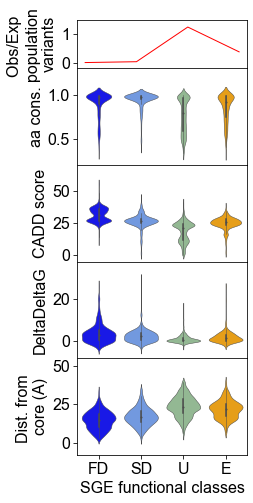

In [7]:
import matplotlib
df=pd.read_csv(out_files+'/DDX3X_mutation_probabilities_time_cluster_ranges_cadd_scores.txt', header=0, sep='\t',index_col=False)
df2=pd.read_csv(out_files+'DDX3X_mutation_probabilities_time_cluster_ranges.txt', header=0, sep='\t',index_col=False)
df3=pd.read_csv(out_files+'DDX3X_mutation_probabilities_time_cluster_ranges_scorecons_scores.txt', header=0, sep='\t',index_col=False)

color_dict={'Fast depleting': 'blue', 'Slow depleting': 'cornflowerblue',  
            'Enriched': 'orange', 'Unchanged':'darkseagreen'}
fig = plt.figure(figsize=(8,8))
gs = matplotlib.gridspec.GridSpec(nrows=5, 
                       ncols=5, 
                       figure=fig, 
                       width_ratios= [2,2, 2,2,2],
                       height_ratios=[1, 2,2,2,2],
                       wspace=0.2,
                       hspace=0.00)
ax1 = fig.add_subplot(gs[0, 0:2])
ax1.set_ylim(-0.2, 1.5)
ax1.set_ylabel('Obs/Exp \npopulation\nvariants', fontsize=16)
ax1.tick_params(axis='y', length=4, labelsize=16)
ax1.tick_params(axis='x', length=0)
b = sns.lineplot(data=df2, x='Class', y='Obs/Exp', color='r', ax=ax1, linewidth=1)
ax1.set(xlabel=None, xticklabels=[])

ax2 = fig.add_subplot(gs[1, 0:2])
sns.violinplot(data=df3, x="Class", y="scorecons", ax=ax2, yticklabels=True, xticklabels=False, palette=color_dict, legend=False, linewidth=0.5, dodge=False, saturation=0.8)
ax2.set(xlabel=None, xticklabels=[])
ax2.set_ylim(0.2, 1.3)
ax2.set_ylabel('aa cons.', fontsize=16)
ax2.tick_params(axis='y', length=4, labelsize=16)

ax3 = fig.add_subplot(gs[2, 0:2])
sns.violinplot(data=df, x="Class", y="cadd", ax=ax3, yticklabels=True, xticklabels=True, palette=color_dict, fontsize=14, legend=False, linewidth=0.5, dodge=False, saturation=0.8)
ax3.set(xlabel=None, xticklabels=[])
ax3.set_ylim(-5, 70)
ax3.set_ylabel('CADD score', fontsize=16)
ax3.tick_params(axis='y', length=4, labelsize=16)

ax4 = fig.add_subplot(gs[3, 0:2])
color_dict={'unchanged':'darkseagreen', 'enriched':'orange',  'slow depleting':'cornflowerblue', 'fast depleting':'blue'}
g=sns.violinplot(data=all_missense,legend=False,  x="SGE_functional_classification", y="DeltaDeltaG", hue = "SGE_functional_classification", palette = color_dict, order=['fast depleting', 'slow depleting', 'unchanged','enriched'], inner='box', linewidth=0.5, dodge=False, saturation=0.8, fontsize=14)
ax4.set(xlabel=None, xticklabels=[])
ax4.set_ylim(-8, 38)
ax4.set_ylabel('DeltaDeltaG', fontsize=16)
ax4.tick_params(axis='y', length=4, labelsize=16)
#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=14)
plt.legend([],[], frameon=False)

ax5 = fig.add_subplot(gs[4, 0:2])
color_dict={'unchanged':'darkseagreen', 'enriched':'orange',  'slow depleting':'cornflowerblue', 'fast depleting':'blue'}
sns.violinplot(data=all_missense,legend=False,  x="SGE_functional_classification", y="Distance_to_core", hue = "SGE_functional_classification", palette = color_dict, order=['fast depleting', 'slow depleting', 'unchanged','enriched'], inner='box', linewidth=0.5, dodge=False, saturation=0.8, fontsize=14, ax=ax5)
ax5.set_xlabel('SGE functional classes', fontsize=16)
ax5.set_xticklabels(['FD', 'SD', 'U', 'E'], fontsize=16)
ax5.set_ylim(-8, 55)
ax5.set_ylabel('Dist. from \ncore (A)', fontsize=16)
ax5.tick_params(axis='y', length=4, labelsize=16)
#g.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1, fontsize=14)
plt.legend([],[], frameon=False)

plt.savefig(out_files+'/Fig3A_Var_cluster_0E_cadd_aacons_plot.pdf', dpi=1300, bbox_inches='tight', transparent = True)
plt.show()


###### 

In [8]:
# Stats for Figure 3A:
# CADD scores
df=pd.read_csv(out_files+'/DDX3X_mutation_probabilities_time_cluster_ranges_cadd_scores.txt', header=0, sep='\t',index_col=False)
df['cadd_default_rank'] = df['cadd'].rank()
df.head()

cadd_FD = df.query('Class == "Fast depleting"')['cadd_default_rank']
cadd_SD= df.query('Class == "Slow depleting"')['cadd_default_rank']
cadd_E= df.query('Class == "Enriched"')['cadd_default_rank']
cadd_U= df.query('Class == "Unchanged"')['cadd_default_rank']
cadd_for_dunn = df[['Class', 'cadd_default_rank']]
cadd_for_dunn.head()
print('KW for cadd scores')
stats.kruskal(cadd_U, cadd_FD, cadd_SD, cadd_E)

KW for cadd scores


KruskalResult(statistic=2138.0225254056927, pvalue=0.0)

In [9]:
# Dunn's post-hoc test for CADD scores
sp.posthoc_dunn(cadd_for_dunn, val_col = 'cadd_default_rank', group_col = 'Class', p_adjust = 'fdr_bh')

,Enriched,Fast depleting,Slow depleting,Unchanged
Enriched,1.000000e+00,1.213429e-41,1.463497e-04,1.423479e-83
Fast depleting,1.213429e-41,1.000000e+00,1.171965e-15,0.000000e+00
Slow depleting,1.463497e-04,1.171965e-15,1.000000e+00,9.932474e-97
Unchanged,1.423479e-83,0.000000e+00,9.932474e-97,1.000000e+00


In [10]:
# Scorecons scores of amino acid conservation
df3=pd.read_csv(out_files+'DDX3X_mutation_probabilities_time_cluster_ranges_scorecons_scores.txt', header=0, sep='\t',index_col=False)
df3['scorecons_default_rank'] = df3['scorecons'].rank()

scorecons_FD = df3.query('Class == "Fast depleting"')['scorecons_default_rank']
scorecons_SD= df3.query('Class == "Slow depleting"')['scorecons_default_rank']
scorecons_E= df3.query('Class == "Enriched"')['scorecons_default_rank']
scorecons_U= df3.query('Class == "Unchanged"')['scorecons_default_rank']
scorecons_for_dunn = df3[['Class', 'scorecons_default_rank']]
scorecons_for_dunn.head()
stats.kruskal(scorecons_U, scorecons_FD, scorecons_SD, scorecons_E)

KruskalResult(statistic=655.207648853587, pvalue=1.0820757540074832e-141)

In [11]:
# Dunn's post-hoc test for scorecons scores
sp.posthoc_dunn(scorecons_for_dunn, val_col = 'scorecons_default_rank', group_col = 'Class', p_adjust = 'fdr_bh')

,Enriched,Fast depleting,Slow depleting,Unchanged
Enriched,1.000000e+00,3.999009e-09,5.202018e-13,5.582231e-24
Fast depleting,3.999009e-09,1.000000e+00,2.031282e-02,6.894672e-81
Slow depleting,5.202018e-13,2.031282e-02,1.000000e+00,1.241836e-66
Unchanged,5.582231e-24,6.894672e-81,1.241836e-66,1.000000e+00


In [12]:
# Calculating chi squared values for the number of variants of each class observed in UKBB and GnomAD
df2=pd.read_csv(out_files+'/DDX3X_mutation_probabilities_time_cluster_ranges.txt', header=0, sep='\t',index_col=False)
df2['(O-E)^2/E']=((df2['observed']-df2['expected'])*(df2['observed']-df2['expected']))/df2['expected']

FD_chi_p = 1 - stats.chi2.cdf((df2.query('Class == "Fast depleting"')['(O-E)^2/E']), 1)
SD_chi_p = 1 - stats.chi2.cdf((df2.query('Class == "Slow depleting"')['(O-E)^2/E']), 1)
E_chi_p = 1 - stats.chi2.cdf(df2.query('Class == "Enriched "')['(O-E)^2/E'], 1)
U_chi_p = 1 - stats.chi2.cdf(df2.query('Class == "Unchanged"')['(O-E)^2/E'], 1)
print('Fast depleting chi squared p =', FD_chi_p)
print('Slow depleting chi squared p =', SD_chi_p)
print('Enriched chi squared p =', E_chi_p)
print('Unchanged chi squared p =', U_chi_p)

Fast depleting chi squared p = [7.03215264e-12]
Slow depleting chi squared p = [1.96874929e-08]
Enriched chi squared p = [0.00025006]
Unchanged chi squared p = [5.1576394e-07]


In [13]:
#Kruskal Wallis test for difference in DDG
#Only look at those missense values for which we have DDG information (not for all of them as we don't have the protein structural info for all of them)
ddG=all_missense.query('DeltaDeltaG != "NaN"')
ddG['ddG_default_rank'] = ddG['DeltaDeltaG'].rank()
ddG['ddG_default_rank']

FD_ddg=ddG.query('SGE_functional_classification == "fast depleting"')['ddG_default_rank']
SD_ddg=ddG.query('SGE_functional_classification == "slow depleting"')['ddG_default_rank']
U_ddg=ddG.query('SGE_functional_classification == "unchanged"')['ddG_default_rank']
E_ddg=ddG.query('SGE_functional_classification == "enriched"')['ddG_default_rank']

stats.kruskal(U_ddg, FD_ddg, SD_ddg, E_ddg)

<ipython-input-13-4438c32e733a>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddG['ddG_default_rank'] = ddG['DeltaDeltaG'].rank()


KruskalResult(statistic=252.55193609570063, pvalue=1.835983687160525e-54)

In [14]:
#Dunn's post-test for difference in DDG
ddG_for_dunn = ddG[['SGE_functional_classification', 'ddG_default_rank']]
ddG_for_dunn.head()
sp.posthoc_dunn(ddG_for_dunn, val_col = 'ddG_default_rank', group_col = 'SGE_functional_classification', p_adjust = 'fdr_bh')

,enriched,fast depleting,slow depleting,unchanged
enriched,1.000000e+00,1.500806e-06,2.231298e-03,2.354092e-11
fast depleting,1.500806e-06,1.000000e+00,1.365630e-01,3.859578e-39
slow depleting,2.231298e-03,1.365630e-01,1.000000e+00,1.861656e-23
unchanged,2.354092e-11,3.859578e-39,1.861656e-23,1.000000e+00


In [15]:
#Kruskal Wallis test for difference in missense variants distance to core
core_missense = all_missense.query('Distance_to_core !="" and Distance_to_core != "NaN"')
core_dist_FD = core_missense.query('SGE_functional_classification == "fast depleting"')['Distance_to_core']
core_dist_SD= core_missense.query('SGE_functional_classification == "slow depleting"')['Distance_to_core']
core_dist_E= core_missense.query('SGE_functional_classification == "enriched"')['Distance_to_core']
core_dist_U= core_missense.query('SGE_functional_classification == "unchanged"')['Distance_to_core']
core_dist_for_dunn = core_missense[['SGE_functional_classification', 'Distance_to_core']]
core_dist_for_dunn.head()
print('KW for core distances, MISSENSE variants')
stats.kruskal(core_dist_U, core_dist_FD, core_dist_SD, core_dist_E)

KW for core distances, MISSENSE variants


KruskalResult(statistic=640.9481762521506, pvalue=1.3362861158337736e-138)

In [16]:
sp.posthoc_dunn(core_dist_for_dunn, val_col = 'Distance_to_core', group_col = 'SGE_functional_classification', p_adjust = 'fdr_bh')

,enriched,fast depleting,slow depleting,unchanged
enriched,1.000000e+00,1.019694e-39,2.181965e-19,7.126799e-07
fast depleting,1.019694e-39,1.000000e+00,6.073356e-04,1.124958e-106
slow depleting,2.181965e-19,6.073356e-04,1.000000e+00,1.453840e-55
unchanged,7.126799e-07,1.124958e-106,1.453840e-55,1.000000e+00


In [18]:
# Dunn's post-hoc test for inframe distance to core scores
core=not_snvre.query('Distance_to_core !="" and Distance_to_core != "NaN"')
core_inframe_del = core.query('Variant_design_type == "inframe"')
core_dist_for_dunn = core_inframe_del[['SGE_functional_classification', 'Distance_to_core']]
core_dist_for_dunn.head()

,SGE_functional_classification,Distance_to_core
457,fast depleting,14.869112
472,fast depleting,18.592417
488,fast depleting,23.770103
504,fast depleting,27.672748
520,fast depleting,22.812661


In [19]:
sp.posthoc_dunn(core_dist_for_dunn, val_col = 'Distance_to_core', group_col = 'SGE_functional_classification', p_adjust = 'fdr_bh')

,enriched,fast depleting,slow depleting,unchanged
enriched,1.000000,8.915674e-06,0.163723,7.072972e-01
fast depleting,0.000009,1.000000e+00,0.000048,4.840110e-14
slow depleting,0.163723,4.776355e-05,1.000000,1.856446e-02
unchanged,0.707297,4.840110e-14,0.018564,1.000000e+00


In [20]:
''' Analysing residues that interact with RNA, ATP and Mg, for inframe and missense variants'''
df=pd.read_csv(data_root+'Table_S9_SGE_data_for_all_variants_tested_with_annotation.txt', header=0, sep='\t',index_col=False)
not_snvre=df.query('Variant_design_type!="snvre"')

#Interpro lists of binding sites
RNA_binding=[274, 275, 276, 302, 303, 323, 324, 325, 326, 329, 351, 357]
ATP_binding=[160, 170, 182, 200, 202, 203, 204, 207, 225, 226, 227, 228, 229, 230, 231, 347, 348, 383, 504, 506, 531, 534, 535]
Mg_binding=[153, 224, 226, 227, 228, 229, 230, 231, 275, 276, 277, 302, 323, 347, 348, 356, 360, 368, 382, 383, 481, 504, 507, 509, 510, 531, 532, 534]

def interacting_residue(row):
    prot_pos=row['Simplified_protein_pos']
    interaction='-'
    if prot_pos != '-':
        prot_pos = int(prot_pos)
        if prot_pos in RNA_binding:
            if interaction == '-':
                interaction = 'RNA'
            else:
                interaction = interaction+',RNA'
            #print('RNA found', interaction, prot_pos)

        if prot_pos in ATP_binding:
            if interaction == '-':
                interaction = 'ATP'
            else:
                interaction = interaction+',ATP'
            #print('ATP found', interaction, prot_pos)
        if prot_pos in Mg_binding:
            if interaction == '-':
                interaction = 'Mg'
            else:
                interaction = interaction+',Mg'
            #print('Mg found', interaction, prot_pos)
    return interaction
   
def test_interaction(row):
    prot_pos=row['Simplified_protein_pos']
    if prot_pos != '-':
        prot_pos = int(prot_pos)
        if prot_pos in interaction_list:
            return 'bound'
        else:
            return '-'
    else:
        return '-'

        
not_snvre['Ligand_binding'] = not_snvre.apply(interacting_residue, axis=1)
interaction_list = RNA_binding
not_snvre['RNA_binding'] = not_snvre.apply(test_interaction, axis=1)
interaction_list = ATP_binding
not_snvre['ATP_binding'] = not_snvre.apply(test_interaction, axis=1)
interaction_list = Mg_binding
not_snvre['Mg_binding'] = not_snvre.apply(test_interaction, axis=1)

<ipython-input-20-a61f90c604fb>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_snvre['Ligand_binding'] = not_snvre.apply(interacting_residue, axis=1)
<ipython-input-20-a61f90c604fb>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_snvre['RNA_binding'] = not_snvre.apply(test_interaction, axis=1)
<ipython-input-20-a61f90c604fb>:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

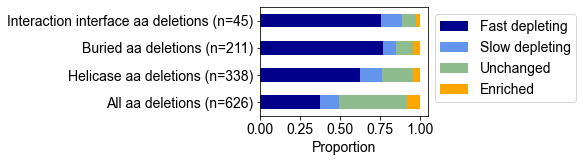

Chi squared, INFRAME vars, interacting interfaces
Power_divergenceResult(statistic=array([13.10665939,  2.01749933,  0.11623323, 18.90321007]), pvalue=array([2.94247921e-04, 1.55495035e-01, 7.33156318e-01, 1.37521066e-05]))

Chi squared, INFRAME vars, buried/not buried
Power_divergenceResult(statistic=array([173.82170133,  18.89859912,  18.91341046,  39.36455449]), pvalue=array([1.08273369e-39, 1.37853863e-05, 1.36787712e-05, 3.51622166e-10]))

Chi squared, INFRAME vars, Helicase


Power_divergenceResult(statistic=array([ 91.61700566,  13.60011834,   2.39102395, 123.2901433 ]), pvalue=array([1.05185183e-21, 2.26171268e-04, 1.22033673e-01, 1.20477962e-28]))

In [21]:
''' Analysing residues that interact with RNA, ATP and Mg, for inframe variants'''
inframe=not_snvre.query('Variant_design_type == "inframe"')
inframe_interacting=inframe.query('Ligand_binding != "-"')
inframe_not_interacting = inframe.query('Ligand_binding == "-"')
inframe_enriched = inframe.query('SGE_functional_classification == "enriched"')
inframe_slow_depleting = inframe.query('SGE_functional_classification == "slow depleting"')
inframe_fast_depleting = inframe.query('SGE_functional_classification == "fast depleting"')
inframe_enriched_interacting = inframe_enriched.query('Ligand_binding != "-"')
inframe_enriched_not_interacting = inframe_enriched.query('Ligand_binding == "-"')
inframe_slow_depleting_interacting = inframe_slow_depleting.query('Ligand_binding != "-"')
inframe_slow_depleting_not_interacting = inframe_slow_depleting.query('Ligand_binding == "-"')
inframe_fast_depleting_interacting = inframe_fast_depleting.query('Ligand_binding != "-"')
inframe_fast_depleting_not_interacting = inframe_fast_depleting.query('Ligand_binding == "-"')
inframe_unaffected = inframe.query('SGE_functional_classification == "unchanged"')
inframe_unaffected_interacting = inframe_unaffected.query('Ligand_binding != "-"')
inframe_unaffected_not_interacting = inframe_unaffected.query('Ligand_binding == "-"')

inframe_RNA_interacting = inframe.query('RNA_binding != "-"')
inframe_not_RNA_interacting = inframe.query('RNA_binding == "-"')
inframe_enriched_RNA_interacting = inframe_enriched.query('RNA_binding != "-"')
inframe_enriched_not_RNA_interacting = inframe_enriched.query('RNA_binding == "-"')
inframe_slow_depleting_RNA_interacting = inframe_slow_depleting.query('RNA_binding != "-"')
inframe_slow_depleting_not_RNA_interacting = inframe_slow_depleting.query('RNA_binding == "-"')
inframe_fast_depleting_RNA_interacting = inframe_fast_depleting.query('RNA_binding != "-"')
inframe_fast_depleting_not_RNA_interacting = inframe_fast_depleting.query('RNA_binding == "-"')
inframe_unaffected_RNA_interacting = inframe_unaffected.query('RNA_binding != "-"')
inframe_unaffected_not_RNA_interacting = inframe_unaffected.query('RNA_binding == "-"')

inframe_ATP_interacting=inframe.query('ATP_binding != "-"')
inframe_not_ATP_interacting = inframe.query('ATP_binding == "-"')
inframe_enriched_ATP_interacting = inframe_enriched.query('ATP_binding != "-"')
inframe_enriched_not_ATP_interacting = inframe_enriched.query('ATP_binding == "-"')
inframe_slow_depleting_ATP_interacting = inframe_slow_depleting.query('ATP_binding != "-"')
inframe_slow_depleting_not_ATP_interacting = inframe_slow_depleting.query('ATP_binding == "-"')
inframe_fast_depleting_ATP_interacting = inframe_fast_depleting.query('ATP_binding != "-"')
inframe_fast_depleting_not_ATP_interacting = inframe_fast_depleting.query('ATP_binding == "-"')
inframe_unaffected_ATP_interacting = inframe_unaffected.query('ATP_binding != "-"')
inframe_unaffected_not_ATP_interacting = inframe_unaffected.query('ATP_binding == "-"')

inframe_Mg_interacting = inframe.query('Mg_binding != "-"')
inframe_not_Mg_interacting = inframe.query('Mg_binding == "-"')
inframe_enriched_Mg_interacting = inframe_enriched.query('Mg_binding != "-"')
inframe_enriched_not_Mg_interacting = inframe_enriched.query('Mg_binding == "-"')
inframe_slow_depleting_Mg_interacting = inframe_slow_depleting.query('Mg_binding != "-"')
inframe_slow_depleting_not_Mg_interacting = inframe_slow_depleting.query('Mg_binding == "-"')
inframe_fast_depleting_Mg_interacting = inframe_fast_depleting.query('Mg_binding != "-"')
inframe_fast_depleting_not_Mg_interacting = inframe_fast_depleting.query('Mg_binding == "-"')
inframe_unaffected_Mg_interacting = inframe_unaffected.query('Mg_binding != "-"')
inframe_unaffected_not_Mg_interacting = inframe_unaffected.query('Mg_binding == "-"')

inframe_wi_core_structure=inframe.query('mean_SASA != "NaN"')
inframe_enriched_core = inframe_wi_core_structure.query('SGE_functional_classification == "enriched"')
inframe_slow_depleting_core = inframe_wi_core_structure.query('SGE_functional_classification == "slow depleting"')
inframe_fast_depleting_core = inframe_wi_core_structure.query('SGE_functional_classification == "fast depleting"')
inframe_enriched_buried = inframe_enriched_core.query('SASA_cat == "buried"')
inframe_slow_depleting_buried = inframe_slow_depleting_core.query('SASA_cat =="buried"')
inframe_fast_depleting_buried = inframe_fast_depleting_core.query('SASA_cat =="buried"')
inframe_unaffected_core = inframe_wi_core_structure.query('SGE_functional_classification == "unchanged"')
inframe_unaffected_buried = inframe_unaffected_core.query('SASA_cat =="buried"')
inframe_buried = inframe_wi_core_structure.query('SASA_cat == "buried"')

H_inframe=inframe.query('VCF_position >= 41343303 and VCF_position <=41345440 or VCF_position >= 41345473 and VCF_position<= 41346966')
H_inframe_enriched = H_inframe.query('SGE_functional_classification == "enriched"')
H_inframe_fast_dep = H_inframe.query('SGE_functional_classification == "fast depleting"')
H_inframe_slow_dep = H_inframe.query('SGE_functional_classification == "slow depleting"')
H_inframe_unaffected = H_inframe.query('SGE_functional_classification == "unchanged"')

with open(out_files+'/Inframe_intrinsic_interactions.txt', 'w') as out:
    header = '\t'.join(['Group', 'Fast depleting', 'Slow depleting', 'Unchanged', 'Enriched'])+'\n'
    out.write(header)
    line1='\t'.join(['Interaction interface aa deletions (n=45)', str(len(inframe_fast_depleting_interacting)/len(inframe_interacting)), str(len(inframe_slow_depleting_interacting)/len(inframe_interacting)), str(len(inframe_unaffected_interacting)/len(inframe_interacting)), str(len(inframe_enriched_interacting)/len(inframe_interacting))])+'\n'
    line2='\t'.join(['Mg interacting (n=27)', str(len(inframe_fast_depleting_Mg_interacting)/len(inframe_Mg_interacting)), str(len(inframe_slow_depleting_Mg_interacting)/len(inframe_Mg_interacting)), str(len(inframe_unaffected_Mg_interacting)/len(inframe_Mg_interacting)), str(len(inframe_enriched_Mg_interacting)/len(inframe_Mg_interacting))])+'\n'
    line3='\t'.join(['ATP interacting (n=22)', str(len(inframe_fast_depleting_ATP_interacting)/len(inframe_ATP_interacting)), str(len(inframe_slow_depleting_ATP_interacting)/len(inframe_ATP_interacting)), str(len(inframe_unaffected_ATP_interacting)/len(inframe_ATP_interacting)), str(len(inframe_enriched_ATP_interacting)/len(inframe_ATP_interacting))])+'\n'
    line4='\t'.join(['RNA interacting (n=11)', str(len(inframe_fast_depleting_RNA_interacting)/len(inframe_RNA_interacting)), str(len(inframe_slow_depleting_RNA_interacting)/len(inframe_RNA_interacting)), str(len(inframe_unaffected_RNA_interacting)/len(inframe_RNA_interacting)), str(len(inframe_enriched_RNA_interacting)/len(inframe_RNA_interacting))])+'\n'
    line5='\t'.join(['Helicase aa deletions (n=338)', str(len(H_inframe_fast_dep)/len(H_inframe)), str(len(H_inframe_slow_dep)/len(H_inframe)), str(len(H_inframe_unaffected)/len(H_inframe)), str(len(H_inframe_enriched)/len(H_inframe))])+'\n'
    line7='\t'.join(['All aa deletions (n=626)', str(len(inframe_fast_depleting)/len(inframe)), str(len(inframe_slow_depleting)/len(inframe)), str(len(inframe_unaffected)/len(inframe)), str(len(inframe_enriched)/len(inframe))])+'\n'
    line6='\t'.join(['Buried aa deletions (n=211)', str(len(inframe_fast_depleting_buried)/len(inframe_buried)), str(len(inframe_slow_depleting_buried)/len(inframe_buried)), str(len(inframe_unaffected_buried)/len(inframe_buried)), str(len(inframe_enriched_buried)/len(inframe_buried))])+'\n'
    out.write(line7)
    out.write(line5)
    out.write(line6)
    #out.write(line3)
    #out.write(line2)
    #out.write(line4)
    out.write(line1)

df = pd.read_csv(out_files+'/Inframe_intrinsic_interactions.txt', '\t')
import matplotlib.pyplot as plt
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (3,2)

df.plot(
    x = 'Group',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=[  'darkblue','cornflowerblue','darkseagreen','orange'], mark_right = True)
plt.xlabel('Proportion', fontsize=14)
plt.title('')
plt.ylabel('', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(out_files+'/Fig3C_cdel_interacting_helicase_distrib.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


# chi squared statistics codon deletion variants interacting vs not interacting, calculated relative to all codon deletions:
# Order: unaffected, enriched, slow, fast vs all codon deletions
interacting=[len(inframe_unaffected_interacting),len(inframe_enriched_interacting), len(inframe_slow_depleting_interacting),len(inframe_fast_depleting_interacting)]
not_interacting = [len(inframe_unaffected)-len(inframe_unaffected_interacting),len(inframe_enriched)-len(inframe_enriched_interacting),len(inframe_slow_depleting)-len(inframe_slow_depleting_interacting),len(inframe_fast_depleting)-len(inframe_fast_depleting_interacting)]
interacting_not_interacting = np.array([interacting, not_interacting])
#expected calculated on inframe proportions of interacting/not interacting
exp_interacting=[(len(inframe_unaffected)/len(inframe))*len(inframe_interacting),(len(inframe_enriched)/len(inframe))*len(inframe_interacting),(len(inframe_slow_depleting)/len(inframe))*len(inframe_interacting),(len(inframe_fast_depleting)/len(inframe))*len(inframe_interacting)]
exp_not_interacting=[(len(inframe_unaffected)/len(inframe))*(len(inframe)-len(inframe_interacting)),(len(inframe_enriched)/len(inframe))*(len(inframe)-len(inframe_interacting)),(len(inframe_slow_depleting)/len(inframe))*(len(inframe)-len(inframe_interacting)),(len(inframe_fast_depleting)/len(inframe))*(len(inframe)-len(inframe_interacting))]
exp = np.array([exp_interacting, exp_not_interacting])
print('Chi squared, INFRAME vars, interacting interfaces')
print(chisquare(interacting_not_interacting, f_exp = exp))

buried=[len(inframe_unaffected_buried),len(inframe_enriched_buried), len(inframe_slow_depleting_buried),len(inframe_fast_depleting_buried)]
not_buried = [len(inframe_unaffected)-len(inframe_unaffected_buried),len(inframe_enriched)-len(inframe_enriched_buried),len(inframe_slow_depleting)-len(inframe_slow_depleting_buried),len(inframe_fast_depleting)-len(inframe_fast_depleting_buried)]
buried_not_buried = np.array([buried, not_buried])
#expected calculated on inframe proportions of buried/not buried within the core structural region
exp_buried=[(len(inframe_unaffected)/len(inframe_wi_core_structure))*len(inframe_buried),(len(inframe_enriched)/len(inframe_wi_core_structure))*len(inframe_buried),(len(inframe_slow_depleting)/len(inframe_wi_core_structure))*len(inframe_buried),(len(inframe_fast_depleting)/len(inframe_wi_core_structure))*len(inframe_buried)]
exp_not_buried=[(len(inframe_unaffected)/len(inframe_wi_core_structure))*(len(inframe_wi_core_structure)-len(inframe_buried)),(len(inframe_enriched)/len(inframe_wi_core_structure))*(len(inframe_wi_core_structure)-len(inframe_buried)),(len(inframe_slow_depleting)/len(inframe_wi_core_structure))*(len(inframe_wi_core_structure)-len(inframe_buried)),(len(inframe_fast_depleting)/len(inframe_wi_core_structure))*(len(inframe_wi_core_structure)-len(inframe_buried))]
exp = np.array([exp_buried, exp_not_buried])
print('\nChi squared, INFRAME vars, buried/not buried')
print(chisquare(buried_not_buried, f_exp = exp))

# Chi-squared test Figure 2D considering both helicase domains together
H=[len(H_inframe_unaffected), len(H_inframe_enriched), len(H_inframe_slow_dep),len(H_inframe_fast_dep)]
not_H = [len(inframe_unaffected)-len(H_inframe_unaffected), len(inframe_enriched)-len(H_inframe_enriched), len(inframe_slow_depleting)-len(H_inframe_slow_dep),len(inframe_fast_depleting)-len(H_inframe_fast_dep)]
H_not_H = np.array([H, not_H])
#expected calculated on missense proportions of within/not the helicase domains (both helicase domains considered together)
exp_H=[(len(inframe_unaffected)/len(inframe))*len(H_inframe),(len(inframe_enriched)/len(inframe))*len(H_inframe),(len(inframe_slow_depleting)/len(inframe))*len(H_inframe),(len(inframe_fast_depleting)/len(inframe))*len(H_inframe)]
exp_not_H=[(len(inframe_unaffected)/len(inframe))*(len(inframe)-len(H_inframe)),(len(inframe_enriched)/len(inframe))*(len(inframe)-len(H_inframe)),(len(inframe_slow_depleting)/len(inframe))*(len(inframe)-len(H_inframe)),(len(inframe_fast_depleting)/len(inframe))*(len(inframe)-len(H_inframe))]
exp = np.array([exp_H, exp_not_H])
# order: unaffected, enriched, slow depleting, fast depleting
print('\nChi squared, INFRAME vars, Helicase')
chisquare(H_not_H, f_exp = exp)

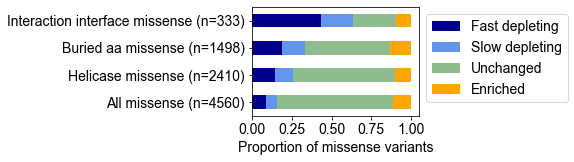


Chi squared, MISSENSE vars, interacting interface
Power_divergenceResult(statistic=array([104.01988331,   1.10681112,  87.38145946, 488.46880917]), pvalue=array([2.00295868e-024, 2.92776192e-001, 8.94854130e-021, 3.06890081e-108]))

Chi squared, MISSENSE vars, buried/not buried
Power_divergenceResult(statistic=array([766.67726376,  20.98511012,  43.97847256,  80.97446753]), pvalue=array([9.48891630e-169, 4.62866763e-006, 3.32007400e-011, 2.28652918e-019]))

Chi squared, MISSENSEvars, Helicase


Power_divergenceResult(statistic=array([ 47.46636572,   8.30908259, 119.06573433, 175.57848113]), pvalue=array([5.59558324e-12, 3.94473113e-03, 1.01315766e-27, 4.47592118e-40]))

In [22]:
''' Analysing residues that interact with RNA, ATP and Mg, for missense variants'''
missense=not_snvre.query('Variant_design_type == "snv" and Primary_consequence == "missense_variant"')
miss_interacting=missense.query('Ligand_binding != "-"')
miss_enriched = missense.query('SGE_functional_classification == "enriched"')
miss_slow_depleting = missense.query('SGE_functional_classification == "slow depleting"')
miss_fast_depleting = missense.query('SGE_functional_classification == "fast depleting"')
miss_enriched_interacting = miss_enriched.query('Ligand_binding != "-"')
miss_enriched_not_interacting = miss_enriched.query('Ligand_binding == "-"')
miss_slow_depleting_interacting = miss_slow_depleting.query('Ligand_binding != "-"')
miss_slow_depleting_not_interacting = miss_slow_depleting.query('Ligand_binding == "-"')
miss_fast_depleting_interacting = miss_fast_depleting.query('Ligand_binding != "-"')
miss_fast_depleting_not_interacting = miss_fast_depleting.query('Ligand_binding == "-"')
miss_unaffected = missense.query('SGE_functional_classification == "unchanged"')
miss_unaffected_interacting = miss_unaffected.query('Ligand_binding != "-"')
miss_unaffected_not_interacting = miss_unaffected.query('Ligand_binding == "-"')
miss_interacting = missense.query('Ligand_binding != "-"')
miss_not_interacting = missense.query('Ligand_binding == "-"')

miss_RNA_interacting=missense.query('RNA_binding != "-"')
miss_not_RNA_interacting = missense.query('RNA_binding == "-"')
miss_enriched_RNA_interacting = miss_enriched.query('RNA_binding != "-"')
miss_enriched_not_RNA_interacting = miss_enriched.query('RNA_binding == "-"')
miss_slow_depleting_RNA_interacting = miss_slow_depleting.query('RNA_binding != "-"')
miss_slow_depleting_not_RNA_interacting = miss_slow_depleting.query('RNA_binding == "-"')
miss_fast_depleting_RNA_interacting = miss_fast_depleting.query('RNA_binding != "-"')
miss_fast_depleting_not_RNA_interacting = miss_fast_depleting.query('RNA_binding == "-"')
miss_unaffected_RNA_interacting = miss_unaffected.query('RNA_binding != "-"')
miss_unaffected_not_RNA_interacting = miss_unaffected.query('RNA_binding == "-"')

miss_ATP_interacting = missense.query('ATP_binding != "-"')
miss_not_ATP_interacting = missense.query('ATP_binding == "-"')
miss_enriched_ATP_interacting = miss_enriched.query('ATP_binding != "-"')
miss_enriched_not_ATP_interacting = miss_enriched.query('ATP_binding == "-"')
miss_slow_depleting_ATP_interacting = miss_slow_depleting.query('ATP_binding != "-"')
miss_slow_depleting_not_ATP_interacting = miss_slow_depleting.query('ATP_binding == "-"')
miss_fast_depleting_ATP_interacting = miss_fast_depleting.query('ATP_binding != "-"')
miss_fast_depleting_not_ATP_interacting = miss_fast_depleting.query('ATP_binding == "-"')
miss_unaffected = missense.query('SGE_functional_classification == "unchanged"')
miss_unaffected_ATP_interacting = miss_unaffected.query('ATP_binding != "-"')
miss_unaffected_not_ATP_interacting = miss_unaffected.query('ATP_binding == "-"')

miss_Mg_interacting = missense.query('Mg_binding != "-"')
miss_not_Mg_interacting = missense.query('Mg_binding == "-"')
miss_enriched_Mg_interacting = miss_enriched.query('Mg_binding != "-"')
miss_enriched_not_Mg_interacting = miss_enriched.query('Mg_binding == "-"')
miss_slow_depleting_Mg_interacting = miss_slow_depleting.query('Mg_binding != "-"')
miss_slow_depleting_not_Mg_interacting = miss_slow_depleting.query('Mg_binding == "-"')
miss_fast_depleting_Mg_interacting = miss_fast_depleting.query('Mg_binding != "-"')
miss_fast_depleting_not_Mg_interacting = miss_fast_depleting.query('Mg_binding == "-"')
miss_unaffected_Mg_interacting = miss_unaffected.query('Mg_binding != "-"')
miss_unaffected_not_Mg_interacting = miss_unaffected.query('Mg_binding == "-"')

H_missense=missense.query('VCF_position >= 41343303 and VCF_position <=41345440 or VCF_position >= 41345473 and VCF_position<= 41346966')
H_miss_enriched = H_missense.query('SGE_functional_classification == "enriched"')
H_miss_fast_dep = H_missense.query('SGE_functional_classification == "fast depleting"')
H_miss_slow_dep = H_missense.query('SGE_functional_classification == "slow depleting"')
H_miss_unaffected = H_missense.query('SGE_functional_classification == "unchanged"')

miss_wi_core_structure=missense.query('mean_SASA != "NaN"')
miss_enriched_core = miss_wi_core_structure.query('SGE_functional_classification == "enriched"')
miss_slow_depleting_core = miss_wi_core_structure.query('SGE_functional_classification == "slow depleting"')
miss_fast_depleting_core = miss_wi_core_structure.query('SGE_functional_classification == "fast depleting"')
miss_enriched_buried = miss_enriched_core.query('SASA_cat == "buried"')
miss_slow_depleting_buried = miss_slow_depleting_core.query('SASA_cat =="buried"')
miss_fast_depleting_buried = miss_fast_depleting_core.query('SASA_cat =="buried"')
miss_unaffected_core = miss_wi_core_structure.query('SGE_functional_classification == "unchanged"')
miss_unaffected_buried = miss_unaffected_core.query('SASA_cat =="buried"')
miss_buried = miss_wi_core_structure.query('SASA_cat == "buried"')

with open(out_files+'//Missense_intrinsic_interactions.txt', 'w') as out:
    header = '\t'.join(['Group', 'Fast depleting', 'Slow depleting', 'Unchanged', 'Enriched'])+'\n'
    out.write(header)
    line1='\t'.join(['Interaction interface missense (n=333)', str(len(miss_fast_depleting_interacting)/len(miss_interacting)), str(len(miss_slow_depleting_interacting)/len(miss_interacting)), str(len(miss_unaffected_interacting)/len(miss_interacting)), str(len(miss_enriched_interacting)/len(miss_interacting))])+'\n'
    line2='\t'.join(['Mg interacting (n=193)', str(len(miss_fast_depleting_Mg_interacting)/len(miss_Mg_interacting)), str(len(miss_slow_depleting_Mg_interacting)/len(miss_Mg_interacting)), str(len(miss_unaffected_Mg_interacting)/len(miss_Mg_interacting)), str(len(miss_enriched_Mg_interacting)/len(miss_Mg_interacting))])+'\n'
    line3='\t'.join(['ATP interacting (n=166)', str(len(miss_fast_depleting_ATP_interacting)/len(miss_ATP_interacting)), str(len(miss_slow_depleting_ATP_interacting)/len(miss_ATP_interacting)), str(len(miss_unaffected_ATP_interacting)/len(miss_ATP_interacting)), str(len(miss_enriched_ATP_interacting)/len(miss_ATP_interacting))])+'\n'
    line4='\t'.join(['RNA interacting (n=79)', str(len(miss_fast_depleting_RNA_interacting)/len(miss_RNA_interacting)), str(len(miss_slow_depleting_RNA_interacting)/len(miss_RNA_interacting)), str(len(miss_unaffected_RNA_interacting)/len(miss_RNA_interacting)), str(len(miss_enriched_RNA_interacting)/len(miss_RNA_interacting))])+'\n'
    line5='\t'.join(['Helicase missense (n=2410)', str(len(H_miss_fast_dep)/len(H_missense)), str(len(H_miss_slow_dep)/len(H_missense)), str(len(H_miss_unaffected)/len(H_missense)), str(len(H_miss_enriched)/len(H_missense))])+'\n'
    line7='\t'.join(['All missense (n=4560)', str(len(miss_fast_depleting)/len(missense)), str(len(miss_slow_depleting)/len(missense)), str(len(miss_unaffected)/len(missense)), str(len(miss_enriched)/len(missense))])+'\n'
    line6='\t'.join(['Buried aa missense (n=1498)', str(len(miss_fast_depleting_buried)/len(miss_buried)), str(len(miss_slow_depleting_buried)/len(miss_buried)), str(len(miss_unaffected_buried)/len(miss_buried)), str(len(miss_enriched_buried)/len(miss_buried))])+'\n'
    out.write(line7)
    out.write(line5)
    out.write(line6)
    out.write(line1)
    #out.write(line3)
    #out.write(line2)
    #out.write(line4)

df = pd.read_csv(out_files+'/Missense_intrinsic_interactions.txt', '\t')
import matplotlib.pyplot as plt
    
# plot a Stacked Bar Chart using matplotlib

plt.rcParams["figure.figsize"] = (3,2)

df.plot(
    x = 'Group',
    kind = 'barh',
    stacked = True,
    title = 'Stacked Bar Graph',
    color=[  'darkblue','cornflowerblue','darkseagreen','orange'], mark_right = True)
plt.xlabel('Proportion of missense variants', fontsize=14)
plt.title('')
plt.ylabel('', fontsize=14)
plt.legend(bbox_to_anchor=(1, 1), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig(out_files+'/Fig3B_Missense_interacting_helicase_distrib.pdf', dpi=1300, bbox_inches='tight', transparent=True)
plt.show()


# chi squared statistics missense variants interacting vs not interacting, calculated relative to all codon deletions:

interacting=[len(miss_unaffected_interacting),len(miss_enriched_interacting), len(miss_slow_depleting_interacting),len(miss_fast_depleting_interacting)]
not_interacting = [len(miss_unaffected)-len(miss_unaffected_interacting),len(miss_enriched)-len(miss_enriched_interacting),len(miss_slow_depleting)-len(miss_slow_depleting_interacting),len(miss_fast_depleting)-len(miss_fast_depleting_interacting)]
interacting_not_interacting = np.array([interacting, not_interacting])
#expected calculated on inframe proportions of interacting/not interacting
exp_interacting=[(len(miss_unaffected)/len(missense))*len(miss_interacting),(len(miss_enriched)/len(missense))*len(miss_interacting),(len(miss_slow_depleting)/len(missense))*len(miss_interacting),(len(miss_fast_depleting)/len(missense))*len(miss_interacting)]
exp_not_interacting=[(len(miss_unaffected)/len(missense))*(len(missense)-len(miss_interacting)),(len(miss_enriched)/len(missense))*(len(missense)-len(miss_interacting)),(len(miss_slow_depleting)/len(missense))*(len(missense)-len(miss_interacting)),(len(miss_fast_depleting)/len(missense))*(len(missense)-len(miss_interacting))]
exp = np.array([exp_interacting, exp_not_interacting])
print('\nChi squared, MISSENSE vars, interacting interface')
print(chisquare(interacting_not_interacting, f_exp = exp))

buried=[len(miss_unaffected_buried),len(miss_enriched_buried), len(miss_slow_depleting_buried),len(miss_fast_depleting_buried)]
not_buried = [len(miss_unaffected)-len(miss_unaffected_buried),len(miss_enriched)-len(miss_enriched_buried),len(miss_slow_depleting)-len(miss_slow_depleting_buried),len(miss_fast_depleting)-len(miss_fast_depleting_buried)]
buried_not_buried = np.array([buried, not_buried])
#expected calculated on inframe proportions of buried/not buried within the core structural region
exp_buried=[(len(miss_unaffected)/len(miss_wi_core_structure))*len(miss_buried),(len(miss_enriched)/len(miss_wi_core_structure))*len(miss_buried),(len(miss_slow_depleting)/len(miss_wi_core_structure))*len(miss_buried),(len(miss_fast_depleting)/len(miss_wi_core_structure))*len(miss_buried)]
exp_not_buried=[(len(miss_unaffected)/len(miss_wi_core_structure))*(len(miss_wi_core_structure)-len(miss_buried)),(len(miss_enriched)/len(miss_wi_core_structure))*(len(miss_wi_core_structure)-len(miss_buried)),(len(miss_slow_depleting)/len(miss_wi_core_structure))*(len(miss_wi_core_structure)-len(miss_buried)),(len(miss_fast_depleting)/len(miss_wi_core_structure))*(len(miss_wi_core_structure)-len(miss_buried))]
exp = np.array([exp_buried, exp_not_buried])
print('\nChi squared, MISSENSE vars, buried/not buried')
print(chisquare(buried_not_buried, f_exp = exp))

# Chi-squared test Figure 2D considering both helicase domains together
H=[len(H_miss_unaffected), len(H_miss_enriched), len(H_miss_slow_dep),len(H_miss_fast_dep)]
not_H = [len(miss_unaffected)-len(H_miss_unaffected), len(miss_enriched)-len(H_miss_enriched), len(miss_slow_depleting)-len(H_miss_slow_dep),len(miss_fast_depleting)-len(H_miss_fast_dep)]
H_not_H = np.array([H, not_H])
#expected calculated on missense proportions of within/not the helicase domains (both helicase domains considered together)
exp_H=[(len(miss_unaffected)/len(missense))*len(H_missense),(len(miss_enriched)/len(missense))*len(H_missense),(len(miss_slow_depleting)/len(missense))*len(H_missense),(len(miss_fast_depleting)/len(missense))*len(H_missense)]
exp_not_H=[(len(miss_unaffected)/len(missense))*(len(missense)-len(H_missense)),(len(miss_enriched)/len(missense))*(len(missense)-len(H_missense)),(len(miss_slow_depleting)/len(missense))*(len(missense)-len(H_missense)),(len(miss_fast_depleting)/len(missense))*(len(missense)-len(H_missense))]
exp = np.array([exp_H, exp_not_H])
# order: unaffected, enriched, slow depleting, fast depleting
print('\nChi squared, MISSENSEvars, Helicase')
chisquare(H_not_H, f_exp = exp)

In [20]:
print('Mg', len(miss_Mg_interacting), 'ATP', len(miss_ATP_interacting), 'RNA', len(miss_RNA_interacting), 'Helicase', len(H_missense), 'buried', len(miss_buried), len(missense), 'interacting', len(miss_interacting))

Mg 193 ATP 166 RNA 79 Helicase 2410 buried 1498 4560 interacting 333
